In [1]:
import sys
curr_dir = '/user_data/vayzenbe/GitHub_Repos/hemispace'



#add curr_dir to path
sys.path.insert(1, curr_dir)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import seaborn as sns
from glob import glob as glob
from plotnine import *
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
sub_info = pd.read_csv(f'{curr_dir}/sub_info.csv')
patient_subs = sub_info[sub_info['group'] == 'patient']

data_dir = f'{curr_dir}/behavior/words_faces'
results_dir = f'{curr_dir}/results'
fig_dir = f'{curr_dir}/figures'



data_files = glob(f'{data_dir}/*.csv')

#load selectivity data
selectivity_summary = pd.read_csv(f'{results_dir}/selectivity/selectivity_summary.csv')
# for each sub in data_summary, get the sub's code from sub_info
for sub in selectivity_summary['sub'].unique():
    sub_code = sub_info[sub_info['sub'] == sub]['code'].values[0]
    selectivity_summary.loc[selectivity_summary['sub'] == sub, 'sub_code'] = sub_code


In [3]:

sub_summary = pd.DataFrame(columns = ['sub','cond','acc','se','rt'])
n = 1
for sub_file in data_files:
    


    #check if subfile is not empty
    if len(sub_file) != 0:
        sub = sub_file.split('/')[-1].split('_')[0]
    
        temp_summary = pd.DataFrame(columns = sub_summary.columns)
        #glob a file from cond with sub number
        

        #load sub data
        sub_data = pd.read_csv(sub_file)

        #check if expName contains face or word using isin
        if 'face' in sub_data['expName'].values.tolist()[0]:
            cond = 'face'
        elif 'word' in sub_data['expName'].values.tolist()[0]:
            cond = 'word'
        
            
        
    
        curr_data = [sub, cond, sub_data['FW_resp.corr'].mean(), sub_data['FW_resp.corr'].sem(), sub_data[sub_data['FW_resp.corr']==1]['FW_resp.rt'].mean()]

        temp_summary.loc[0] = curr_data
        #temp_summary['age'] = sub_info[sub_info['sub']==sub]['age'].values[0]
        #temp_summary['sex'] = sub_info[sub_info['sub']==sub]['sex'].values[0]

        #check if acc for .3 duration is over .5
        #if temp_summary[temp_summary['duration']==.3]['acc'].values[0] > .5:
        sub_summary = pd.concat([sub_summary, temp_summary], axis = 0)

    else:
        print(f'no file for {sub_file}')

#convert sub summary acc to float
sub_summary['acc'] = sub_summary['acc'].astype(float)



In [60]:
#add group column to sub_summary labeled patient or control
sub_summary['group'] = sub_summary['sub'].apply(lambda x: 'Patient' if x in patient_subs['code'].values else 'Control')

#if patient set intact_hemi to left or right from patient_subs, else set to intact
sub_summary['intact_hemi'] = sub_summary['sub'].apply(lambda x: patient_subs[patient_subs['code']==x]['intact_hemi'].values[0] if x in patient_subs['code'].values else 'Control')


#add sub_code for patients
sub_summary['sub_code'] = sub_summary['sub'].apply(lambda x: str(x) if x in patient_subs['code'].values else '')

#capitalize intact_hemi
sub_summary['intact_hemi'] = sub_summary['intact_hemi'].apply(lambda x: x.capitalize())
#capitalize cond
sub_summary['cond'] = sub_summary['cond'].apply(lambda x: x.capitalize())

#calculate mean and sem for each duration
data_mean = sub_summary.groupby(['cond', 'intact_hemi']).mean().reset_index()
sem = sub_summary.groupby(['cond', 'intact_hemi']).sem().reset_index()
data_mean['se'] = sem['acc']



#Capitalize cond
data_mean['cond'] = data_mean['cond'].apply(lambda x: x.capitalize())
#capitalize intact_hemi
data_mean['intact_hemi'] = data_mean['intact_hemi'].apply(lambda x: x.capitalize())

#Replace left with intact left
sub_summary['intact_hemi'] = sub_summary['intact_hemi'].apply(lambda x: 'Intact left' if x == 'Left' else x)
data_mean['intact_hemi'] = data_mean['intact_hemi'].apply(lambda x: 'Intact left' if x == 'Left' else x)

#Replace right with intact right
data_mean['intact_hemi'] = data_mean['intact_hemi'].apply(lambda x: 'Intact right' if x == 'Right' else x)
sub_summary['intact_hemi'] = sub_summary['intact_hemi'].apply(lambda x: 'Intact right' if x == 'Right' else x)


#set order for condition
cond_order = ['Word', 'Face']
data_mean['cond'] = pd.Categorical(data_mean['cond'], categories = cond_order, ordered = True)
sub_summary['cond'] = pd.Categorical(sub_summary['cond'], categories = cond_order, ordered = True)




#convert all acc to float
data_mean['acc'] = data_mean['acc'].astype(float)
data_mean['se'] = data_mean['se'].astype(float)
sub_summary['acc'] = sub_summary['acc'].astype(float)
sub_summary['se'] = sub_summary['se'].astype(float)


In [13]:
#control_summary = sub_summary[sub_summary['group']=='Control']
#control_summary= control_summary.pivot(index='sub', columns='cond', values='acc')
sub_summary

,sub,cond,acc,se,rt,group,intact_hemi,sub_code
0,5015,Face,0.885417,0.032679,1.318153,Control,Control,
0,5025,Word,0.927083,0.026675,0.437476,Control,Control,
0,5015,Word,0.812500,0.040045,1.466564,Control,Control,
0,FO,Word,0.958333,0.018318,0.710417,Patient,Intact right,FO
0,5024,Word,0.968750,0.017851,1.296718,Control,Control,
...,...,...,...,...,...,...,...,...
0,5030,Word,0.968750,0.017851,0.591155,Control,Control,
0,SI,Word,0.983333,0.011735,0.801652,Patient,Intact left,SI
0,XC,Face,0.933333,0.022866,0.810912,Patient,Intact left,XC
0,5024,Face,0.968750,0.017851,1.116588,Control,Control,


In [55]:
'''
Create confidence intervals, by resampling control data
'''

iters = 10000 #number of resamples
n =4 #how many subs to sample at a time
boot_data = pd.DataFrame(columns = ['Word','Face'])

for cond in ['Word','Face']:
    control_summary = sub_summary[(sub_summary['group']=='Control') & (sub_summary['cond'] == cond)]
    #control_summary= control_summary.pivot(index='sub', columns='cond', values='acc')



    for ii in range(0,iters):

        curr_data = control_summary.sample(n=n,replace=True)

        data_mean = curr_data['acc'].mean()

        #append to boot
        boot_data.loc[ii, cond] = data_mean



resamples = pd.melt(boot_data, var_name='cond', value_name='acc')
resamples['intact_hemi'] = 'Control'

In [80]:
#compute CIs for each duration
alpha = .05
control_cis = pd.DataFrame(columns = ['cond','min','max'])
for coln, col in enumerate(boot_data.columns):
    ci = np.percentile(boot_data[col], [(alpha/2)*100, 100-((alpha/2)*100)])
    

    
    control_cis.loc[len(control_cis.index)] = [col, ci[0], ci[1]] 
    
                            
                            
                            
control_cis['intact_hemi'] = "Control"

In [87]:
def create_acc_plot(data_mean, curr_cond):

    p = ggplot(data_mean, aes(x = 'cond', y = 'acc', fill = 'intact_hemi'))  + \
        geom_label(curr_cond, aes(x = 'cond', y = 'acc',fill = 'intact_hemi', label = 'sub_code'),  position = position_jitterdodge(dodge_width=.6, jitter_width = 0.1, random_state = 1),  size = 8) + \
        geom_linerange(aes(x = 'cond', ymin = 'min', ymax = 'max'), position = position_dodge(width=.6), size = 1) + \
        geom_point(position = position_dodge(width=.6), shape = 'o', size = 4,  stroke = 1)  + \
        xlab('Condition') + ylab('Accuracy') + ylim(.4, 1) + \
        scale_fill_manual(values = ['#808080','#ee7183', '#7398af']) + \
        theme_classic() + ylim(.4,1) + geom_hline(yintercept = .5, linetype = 'dashed', color = 'black', size = 1) + \
        theme(text = element_text(color ='black'), 
            axis_text_x= element_text(angle = 30, size = 12),
            axis_text_y= element_text(size = 12),
            axis_title=element_text(size = 14),
            axis_line=element_line(), 
            panel_border=element_blank(),
            figure_size = (3, 5))+ \
            labs(fill='Group') #+ ggtitle(f'{cond}')
        
        
    p.save(f'{fig_dir}/word_face_behavior.png', width=3, height=5, dpi = 300)
    print(p)

Face


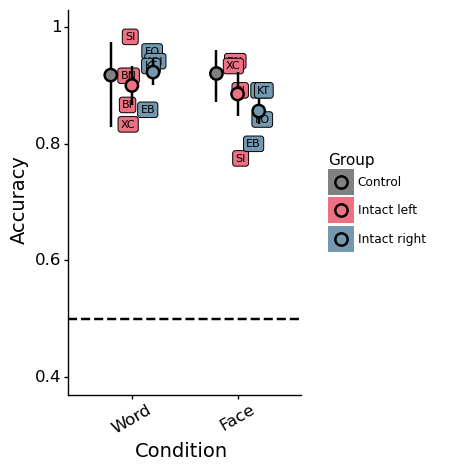

In [88]:
#convert all acc to float
#data_mean['acc'] = data_mean['acc']
#data_mean['se'] = data_mean['se']
#sub_summary['acc'] = sub_summary['acc'].astype(float)
#sub_summary['se'] = sub_summary['se'].astype(float)


data_mean['min'] = data_mean['acc'] - data_mean['se']
data_mean['max'] = data_mean['acc'] + data_mean['se']
data_mean.loc[(data_mean['intact_hemi'] == 'Control') , 'min']=control_cis['min'].values
data_mean.loc[(data_mean['intact_hemi'] == 'Control') , 'max']=control_cis['max'].values



print(cond)
#plot
create_acc_plot(data_mean, sub_summary)

In [9]:
def create_scatter(patient_data):

    p = ggplot(patient_data, aes(x = 'acc', y = 'sum_selec_norm', fill = 'hemi'))  + \
        geom_point(shape = 'o', size = 4,  stroke = 1)  + \
        geom_label(patient_data, aes(x = 'acc', y = 'sum_selec_norm',fill = 'hemi', label = 'sub_code'), size = 8) + \
        xlab('Accuracy') + ylab('Summed Selectivity') + \
        scale_fill_manual(values = ['#ee7183', '#7398af']) + \
        theme_classic() + \
        theme(text = element_text(color ='black'), 
            axis_text_x= element_text(angle = 30, size = 12),
            axis_text_y= element_text(size = 12),
            axis_title=element_text(size = 14),
            axis_line=element_line(), 
            panel_border=element_blank(),
            figure_size = (6, 6))+ \
            labs(fill='Group') #+ ggtitle(f'{cond}')

    print(p)

no behavioral data for BN
word


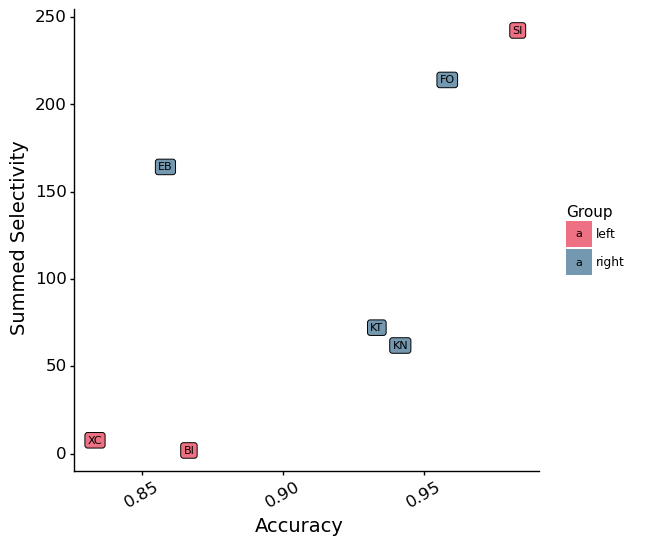


no behavioral data for BI
no behavioral data for BN
face


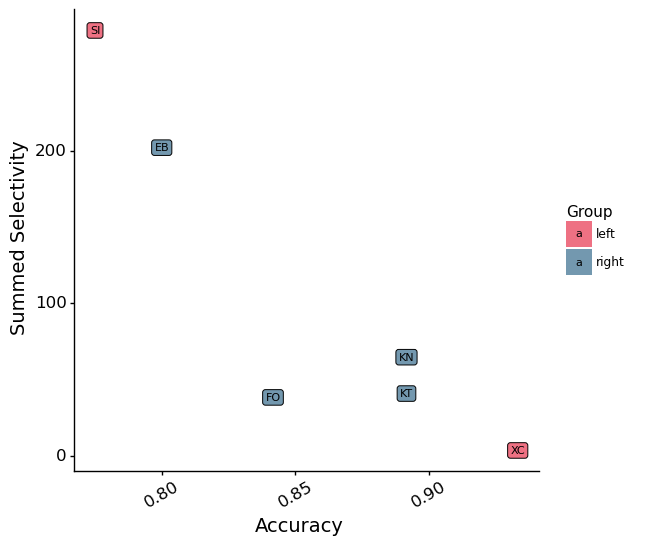

In [10]:
roi = 'ventral_visual_cortex'
for cond in ['word', 'face']:
    #extract patient data for cond and roi
    patient_data = selectivity_summary[(selectivity_summary['cond']==cond) & (selectivity_summary['roi']==roi) & (selectivity_summary['sub'].isin(patient_subs['sub'].values))]
    behavioral_data = sub_summary[(sub_summary['cond']==cond) & (sub_summary['group'] == 'Patient') ]

    #for each sub append behavioral acc to patient data
    for sub in patient_data['sub_code'].unique():
        try:
            patient_data.loc[patient_data['sub_code']==sub, 'acc'] = behavioral_data[behavioral_data['sub_code']==sub]['acc'].values[0]
            #same for rt
            patient_data.loc[patient_data['sub_code']==sub, 'rt'] = behavioral_data[behavioral_data['sub_code']==sub]['rt'].values[0]

        except:
            print(f'no behavioral data for {sub}')

    print(cond)
    create_scatter(patient_data)

In [20]:
behavioral_data[behavioral_data['sub_code']==sub]['acc'].values[0]

IndexError: index 0 is out of bounds for axis 0 with size 0

In [13]:
patient_data

,sub,group,hemi,roi,cond,roi_size,mean_act,volume,sum_selec,sum_selec_norm,sub_code
8,sub-108,patient,right,ventral_visual_cortex,word,43837,3.773206,1908.00000,7199.27730,164.228331,EB
20,sub-109,patient,left,ventral_visual_cortex,word,44367,3.064214,110.00000,337.06354,7.597168,XC
30,sub-hemispace1001,patient,right,ventral_visual_cortex,word,11242,3.435776,997.10009,810.84310,72.126230,KT
41,sub-hemispace1002,patient,left,ventral_visual_cortex,word,50182,3.979457,3057.00000,12165.20100,242.421609,SI
53,sub-hemispace1003,patient,right,ventral_visual_cortex,word,48500,3.580182,2900.00000,10382.52700,214.072729,FO
65,sub-hemispace1004,patient,left,ventral_visual_cortex,word,44656,2.814380,28.00000,78.80264,1.764660,BI
77,sub-hemispace1006,patient,right,ventral_visual_cortex,word,45732,3.610844,784.00000,2830.90190,61.901991,KN
89,sub-hemispace1007,patient,left,ventral_visual_cortex,word,38684,3.305999,509.00000,1682.75370,43.499991,BN
